In [1]:
import random
from functools import partial
import fastcore.all as fc
from datasets import load_dataset
from IPython.display import Markdown

import torch
from torch import nn, optim
from torch.nn import init
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torcheval.metrics import MulticlassAccuracy
from torchvision import transforms
import torchvision.transforms.functional as TF

from minai.datasets import inplace, show_images
from minai.learner import DataLoaders, MetricsCB, ProgressCB, DeviceCB, TrainLearner, Learner, SingleBatchCB, Callback
from minai.resnet import ResBlock
from minai.init import GeneralRelu, init_weights, set_seed, conv, BatchTransformCB
from minai.activations import ActivationStats, Hooks
from minai.sgd import BatchSchedCB
set_seed(42)

/home/studio-lab-user/.conda/envs/fastai/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.9.5) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [2]:
bs=1024
xm, xs = 0.28, 0.35

x, y = 'image', 'label'

@inplace
def transformi(b): b[x] = [(TF.to_tensor(o) - xm)/xs for o in b[x]]

ds = load_dataset('fashion_mnist')
dsd = ds.with_transform(transformi)
dls = DataLoaders.from_dd(dsd, batch_size=bs)

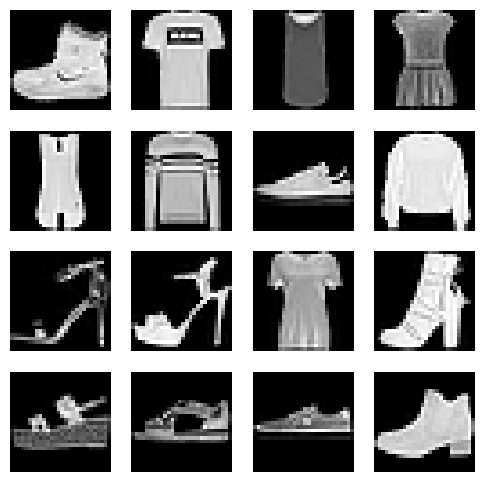

In [3]:
xb, yb = next(iter(dls.train))
show_images(xb[:16], imsize=1.5)

In [4]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(mod_filter=fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, astats, ProgressCB(plot=True)]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [5]:
def get_model(act=act_gr, nfs=[16, 32, 64, 128, 256, 512], norm=nn.BatchNorm2d):
    layers = [ResBlock(1, nfs[0], stride=1, ks=5, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], stride=2, act=act, norm=norm) for i in range(len(nfs) - 1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [6]:
def _flops(x, h, w):
    if x.dim() < 3: return x.numel()
    if x.dim() == 4: return x.numel() * h * w
    raise Exception()
    
@fc.patch
def summary(self:Learner):
    res = '|Layer|Input Shape|Output Shape|Number of params|MFlops|\n|--|--|--|--|--|\n'
    total_params = 0
    total_flops = 0
    def _f(hook, mod, inp, outp):
        nonlocal res, total_params, total_flops
        num_params = sum(o.numel() for o in mod.parameters())
        total_params += num_params
        *_,h, w = outp.shape
        num_flops = sum(_flops(o, h, w) for o in mod.parameters())/1e6
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{num_params}|{num_flops:.1f}|\n'
        total_flops += num_flops
    with Hooks(self.model, _f) as hook: self.fit(1, train=False, cbs=SingleBatchCB(), lr=1e-3)
    print('Total Params: ', total_params)
    print(f'Total Flops: {total_flops:.1f}')
    if fc.IN_NOTEBOOK:
        return Markdown(res)
    else:
        print(res)

In [7]:
epochs=5
lr = 1e-2

In [7]:
TrainLearner(get_model().apply(iw), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Total Params:  4903556
Total Flops: 22.0


|Layer|Input Shape|Output Shape|Number of params|MFlops|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6864|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14432|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57536|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|229760|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|918272|3.7|
|ResBlock|(1024, 256, 2, 2)|(1024, 512, 1, 1)|3671552|3.7|
|Flatten|(1024, 512, 1, 1)|(1024, 512)|0|0.0|
|Linear|(1024, 512)|(1024, 10)|5120|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.793,0.803,0,True
0.848,0.485,0,False
0.888,0.410,1,True
0.861,0.439,1,False
0.914,0.285,2,True
0.911,0.276,2,False
0.937,0.212,3,True
0.919,0.269,3,False
0.958,0.152,4,True
0.927,0.238,4,False


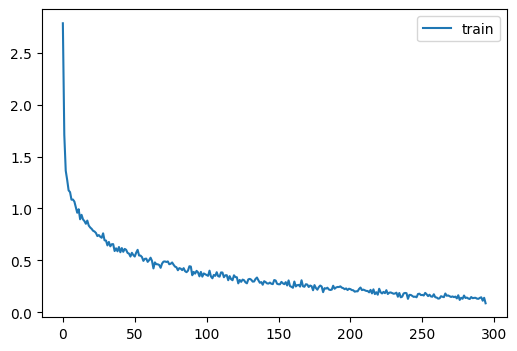

In [8]:
set_seed(42)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=len(dls.train)*epochs)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(get_model().apply(iw), dls, F.cross_entropy, lr=lr, cbs=cbs + xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [8]:
class GlobalAvgPool(nn.Module):
    def forward(self, x):
        return x.mean((-2, -1))

In [10]:
def get_model2(act=act_gr, nfs=[16, 32, 64, 128, 256], norm=nn.BatchNorm2d):
    layers = [ResBlock(1, nfs[0], stride=1, ks=5, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], stride=2, act=act, norm=norm) for i in range(len(nfs) - 1)]
    layers += [ResBlock(256, 512, act=act, norm=norm), GlobalAvgPool()]
    layers += [nn.Linear(512, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [11]:
TrainLearner(get_model2().apply(iw), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Total Params:  4903556
Total Flops: 33.0


|Layer|Input Shape|Output Shape|Number of params|MFlops|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6864|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14432|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57536|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|229760|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|918272|3.7|
|ResBlock|(1024, 256, 2, 2)|(1024, 512, 2, 2)|3671552|14.7|
|GlobalAvgPool|(1024, 512, 2, 2)|(1024, 512)|0|0.0|
|Linear|(1024, 512)|(1024, 10)|5120|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


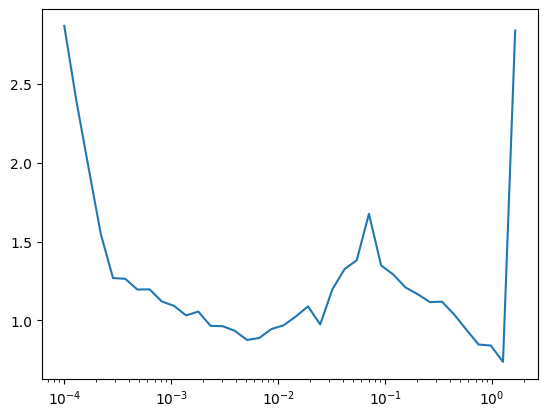

In [23]:
set_seed(42)
learn = TrainLearner(get_model2().apply(iw), dls, F.cross_entropy, lr=lr, cbs=DeviceCB(), opt_func=optim.AdamW).lr_find(start_lr=1e-4)

accuracy,loss,epoch,train
0.784,0.823,0,True
0.837,0.502,0,False
0.886,0.419,1,True
0.867,0.386,1,False
0.913,0.291,2,True
0.908,0.281,2,False
0.936,0.215,3,True
0.919,0.260,3,False
0.957,0.153,4,True
0.925,0.238,4,False


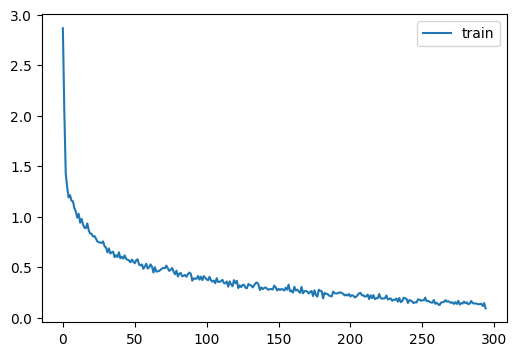

In [24]:
set_seed(42)
epochs=5
lr = 1e-2
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=len(dls.train)*epochs)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(get_model2().apply(iw), dls, F.cross_entropy, lr=lr, cbs=cbs + xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [14]:
def get_model3(act=act_gr, nfs=[16, 32, 64, 128, 256], norm=nn.BatchNorm2d):
    layers = [ResBlock(1, nfs[0], stride=1, ks=5, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], stride=2, act=act, norm=norm) for i in range(len(nfs) - 1)]
    layers += [GlobalAvgPool(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [15]:
TrainLearner(get_model3().apply(iw), dls, F.cross_entropy, lr=lr, cbs=DeviceCB(), opt_func=optim.AdamW).summary()

Total Params:  1229444
Total Flops: 18.3


|Layer|Input Shape|Output Shape|Number of params|MFlops|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6864|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14432|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57536|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|229760|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|918272|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.784,0.823,0,True
0.837,0.502,0,False
0.886,0.419,1,True
0.867,0.386,1,False
0.913,0.291,2,True
0.908,0.281,2,False
0.936,0.215,3,True
0.919,0.260,3,False
0.957,0.153,4,True
0.925,0.238,4,False


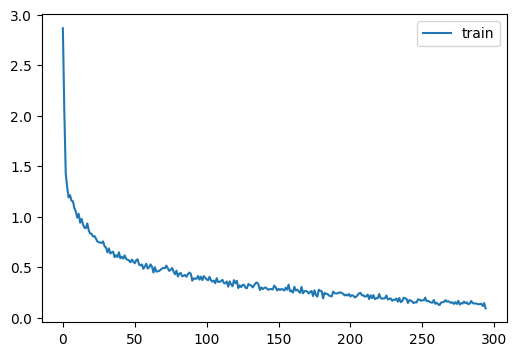

In [16]:
set_seed(42)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=len(dls.train)*epochs)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(get_model3().apply(iw), dls, F.cross_entropy, lr=lr, cbs=cbs + xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [9]:
def get_model4(act=act_gr, nfs=[16, 32, 64, 128, 256], norm=nn.BatchNorm2d):
    layers = [conv(1, nfs[0], stride=1, ks=5, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], stride=2, act=act, norm=norm) for i in range(len(nfs) - 1)]
    layers += [GlobalAvgPool(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [20]:
TrainLearner(get_model4().apply(iw), dls, F.cross_entropy, lr=lr, cbs=DeviceCB(), opt_func=optim.AdamW).summary()

Total Params:  1223028
Total Flops: 13.3


|Layer|Input Shape|Output Shape|Number of params|MFlops|
|--|--|--|--|--|
|Sequential|(1024, 1, 28, 28)|(1024, 16, 28, 28)|448|0.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14432|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57536|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|229760|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|918272|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.793,0.812,0,True
0.855,0.528,0,False
0.893,0.404,1,True
0.841,0.471,1,False
0.915,0.288,2,True
0.904,0.295,2,False
0.937,0.214,3,True
0.916,0.282,3,False
0.958,0.157,4,True
0.923,0.245,4,False


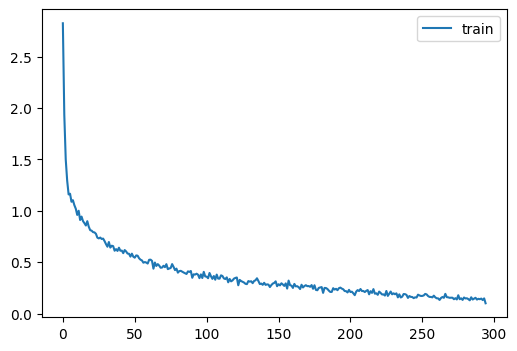

In [25]:
set_seed(42)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=len(dls.train)*epochs)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(get_model4().apply(iw), dls, F.cross_entropy, lr=lr, cbs=cbs + xtra, opt_func=optim.AdamW)
learn.fit(epochs)

## Train for longer

accuracy,loss,epoch,train
0.775,0.882,0,True
0.850,0.614,0,False
0.885,0.544,1,True
0.886,0.469,1,False
0.905,0.419,2,True
0.890,0.382,2,False
0.915,0.328,3,True
0.901,0.300,3,False
0.918,0.280,4,True
0.879,0.362,4,False


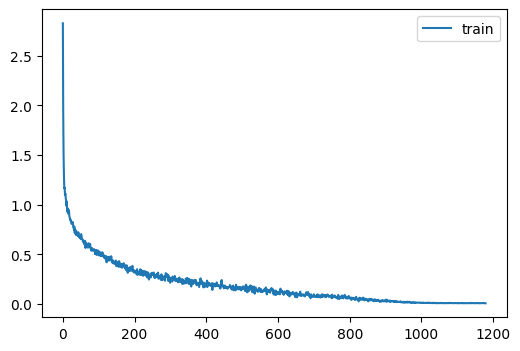

In [26]:
set_seed(42)
epochs = 20
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=len(dls.train)*epochs)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(get_model4().apply(iw), dls, F.cross_entropy, lr=lr, cbs=cbs + xtra, opt_func=optim.AdamW)
learn.fit(epochs)

## Data Augmentation

In [10]:
set_seed(42)
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(p=0.5))

def f(batch, tfm_x=fc.noop, tfm_y=fc.noop): return tfm_x(batch[0]), tfm_y(batch[1])
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=len(dls.train)*epochs)
xtra = [DeviceCB(), BatchSchedCB(sched), BatchTransformCB(partial(f, tfm_x=tfms), on_val=False), SingleBatchCB()]

In [11]:
xb, yb = next(iter(dls.train))

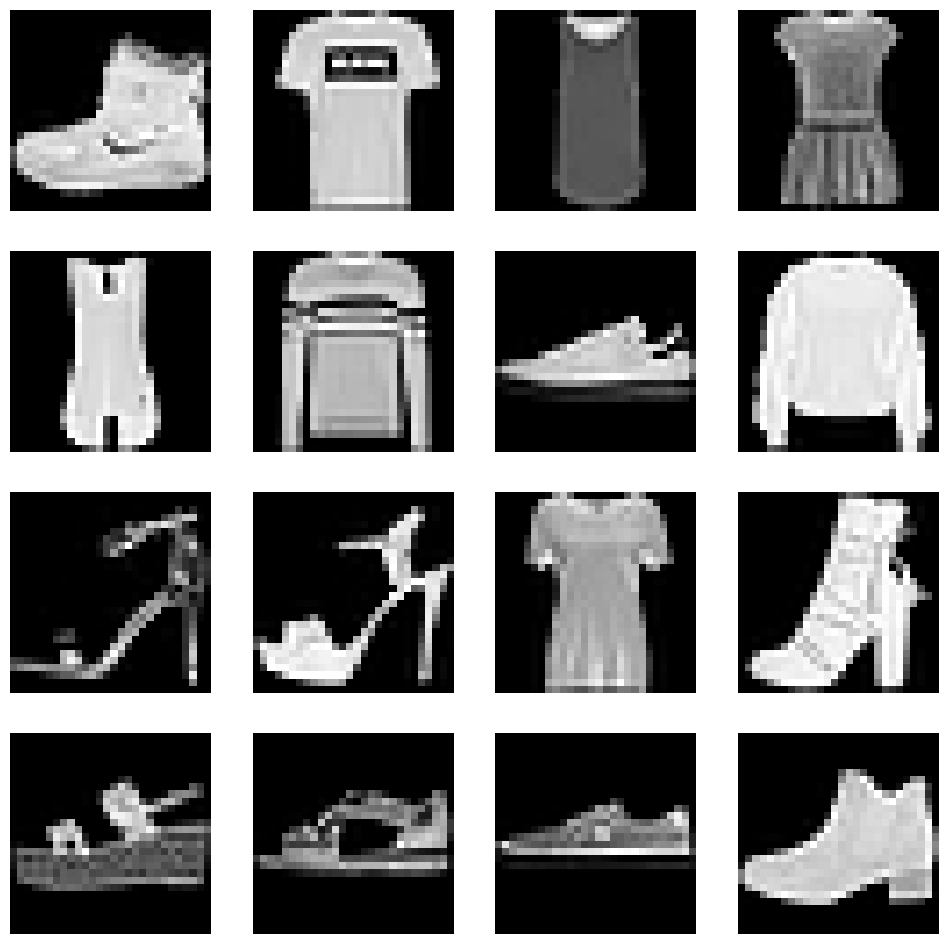

In [12]:
show_images(xb[:16])

In [59]:
learn = TrainLearner(get_model4().apply(iw), dls, F.cross_entropy, lr=lr, cbs= xtra, opt_func=optim.AdamW)
learn.fit(1)

In [60]:
xb, yb = learn.batch

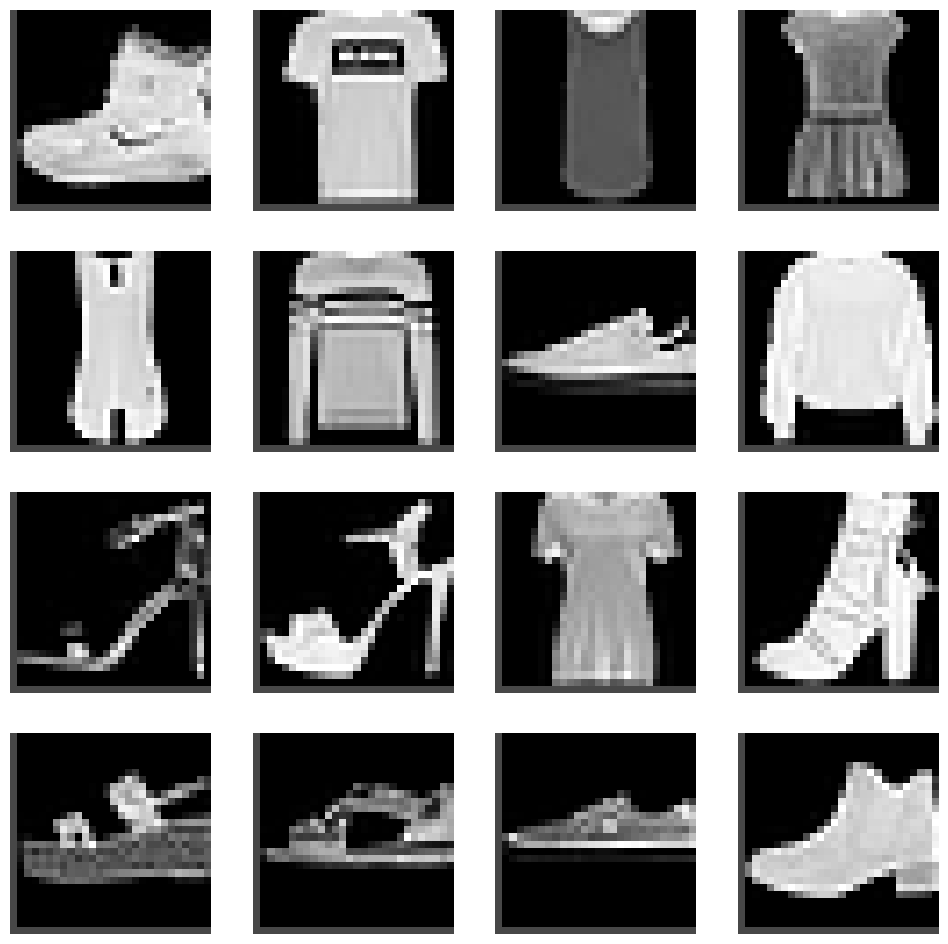

In [61]:
show_images(xb[:16])

accuracy,loss,epoch,train
0.720,1.023,0,True
0.805,0.682,0,False
0.840,0.659,1,True
0.825,0.574,1,False
0.867,0.518,2,True
0.869,0.413,2,False
0.882,0.417,3,True
0.839,0.474,3,False
0.882,0.374,4,True
0.881,0.337,4,False


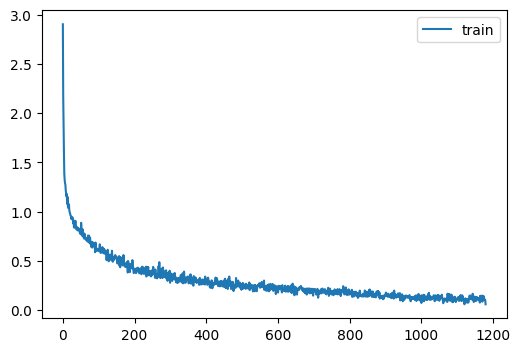

In [ ]:
set_seed(42)
epochs = 20
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=len(dls.train)*epochs)
xtra = [DeviceCB(), BatchSchedCB(sched), BatchTransformCB(partial(f, tfm_x=tfms), on_val=False)]
learn = TrainLearner(get_model4().apply(iw), dls, F.cross_entropy, lr=lr, cbs= cbs + xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [73]:
path = fc.Path('models')
path.mkdir(exist_ok=True)
torch.save(learn.model, path/'fmnist_aug.pkl')

## TTA

In [19]:
path = fc.Path('models')
model = torch.load(path/'fmnist_aug.pkl')

In [20]:
class CapturePreds(Callback):
    def __init__(self):
        self.all_preds = []
        self.all_actual = []
    
    def after_batch(self, learn):
        self.all_preds.extend(learn.preds)
        self.all_actual.extend(learn.batch[1])

In [22]:
set_seed(64)
cp1 = CapturePreds()
TrainLearner(model, dls, F.cross_entropy, cbs=[DeviceCB(), cp1, metrics, ProgressCB(plot=True)]).fit(1, train=False)

accuracy,loss,epoch,train
0.937,0.184,0,False


In [23]:
cp1_preds = torch.stack(cp1.all_preds, dim=0); cp1_preds.shape

torch.Size([10000, 10])

In [24]:
cp1_actual = torch.stack(cp1.all_actual, dim=0); cp1_actual.shape

torch.Size([10000])

In [26]:
cp2 = CapturePreds()
TrainLearner(model, dls, F.cross_entropy, cbs=[DeviceCB(), cp2, BatchTransformCB(partial(f, tfm_x=tfms), on_train=False), metrics, ProgressCB(plot=True)]).fit(1, train=False)

accuracy,loss,epoch,train
0.932,0.195,0,False


In [27]:
cp2_preds = torch.stack(cp2.all_preds, dim=0); cp2_preds.shape

torch.Size([10000, 10])

In [28]:
aggregated_preds = torch.stack((cp1_preds, cp2_preds)).mean(0).argmax(-1)

In [29]:
(aggregated_preds == cp1_actual).float().mean().item()

0.9388999938964844

## Random Erase

In [50]:
xb, yb = next(iter(dls.train))
xb.mean(), xb.std()

(tensor(0.01), tensor(1.01))

In [105]:
x_max, x_min = xb.max().item(), xb.min().item()
x_max, x_min

(2.057142972946167, -0.800000011920929)

In [31]:
img = xb[0][0]

In [24]:
pct=0.2
szx = int(pct * xb.shape[-1])
szy = int(pct * xb.shape[-2])
stx = int(random.random() * (1 - pct) * xb.shape[-1])
sty = int(random.random() * (1 - pct) * xb.shape[-2])

In [33]:
szx, szy, stx, sty

(5, 5, 10, 14)

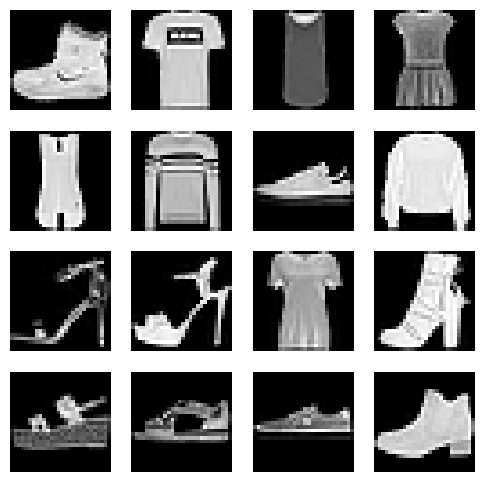

In [46]:
show_images(xb[:16], imsize=1.5)

In [47]:
init.normal_(xb[:, :, stx:stx+szx, sty: sty+ szy], mean = xm, std = xs);

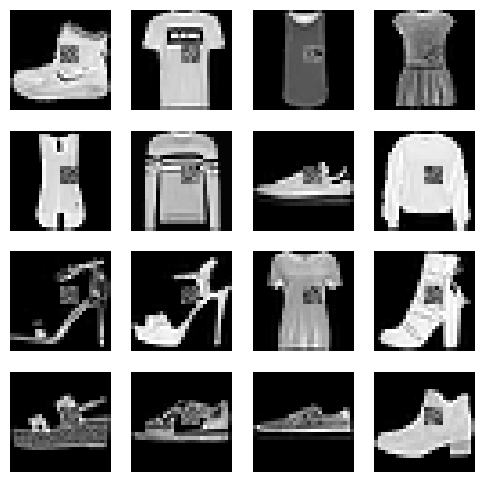

In [48]:
show_images(xb[:16], imsize=1.5)

In [119]:
def _rand_erase(xb):
    szx = int(pct * xb.shape[-1])
    szy = int(pct * xb.shape[-2])
    stx = int(random.random() * (1 - pct) * xb.shape[-1])
    sty = int(random.random() * (1 - pct) * xb.shape[-2])
    init.normal_(xb[:, :, stx:stx+szx, sty: sty+ szy], mean = xm, std = xs)
    xb.clamp_(x_min, x_max)

In [120]:
_rand_erase(xb)

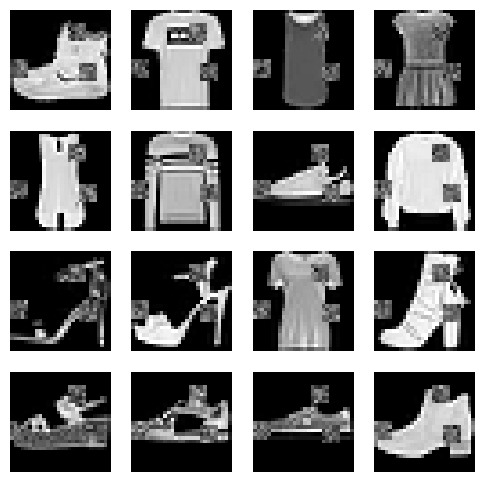

In [121]:
show_images(xb[:16], imsize=1.5)

In [122]:
random.randint(0, 4)

4

In [134]:
def rand_erase(xb, max_n=4):
    n = random.randint(0, max_n)
    for i in range(n): _rand_erase(xb)

In [135]:
class RandomErase(nn.Module):
    def __init__(self, max_n=4):
        super().__init__()
        fc.store_attr()
    def forward(self, x):
        rand_erase(x, self.max_n)
        return x

In [136]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(p=0.5),
                     RandomErase()
                    )

In [137]:
set_seed(42)
learn = TrainLearner(get_model4().apply(iw), dls, F.cross_entropy, cbs=[], lr=lr, opt_func=optim.AdamW)
tfmb = BatchTransformCB(partial(f, tfm_x=tfms))
learn.fit(1, train=False, cbs=[DeviceCB(), tfmb, SingleBatchCB()])

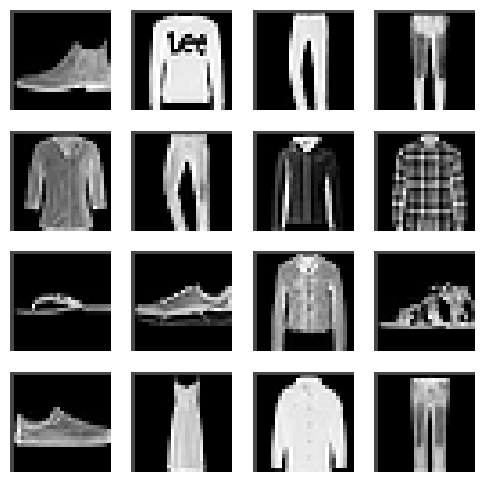

In [138]:
show_images(learn.batch[0][:16], imsize=1.5)

accuracy,loss,epoch,train
0.705,1.061,0,True
0.793,0.692,0,False
0.817,0.721,1,True
0.817,0.598,1,False
0.844,0.585,2,True
0.862,0.437,2,False
0.857,0.486,3,True
0.866,0.399,3,False
0.867,0.418,4,True
0.860,0.418,4,False


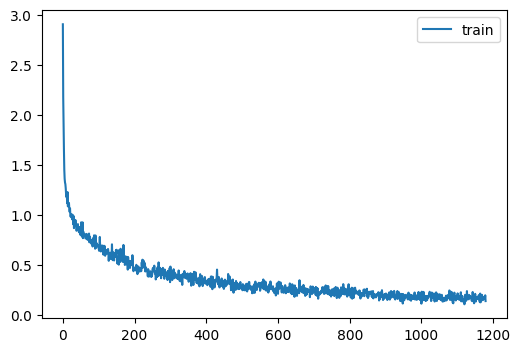

In [139]:
set_seed(42)
epochs = 20
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=len(dls.train)*epochs)
xtra = [DeviceCB(), BatchSchedCB(sched), BatchTransformCB(partial(f, tfm_x=tfms), on_val=False)]
learn = TrainLearner(get_model4().apply(iw), dls, F.cross_entropy, lr=lr, cbs= cbs + xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
path = fc.Path('models')
path.mkdir(exist_ok=True)
torch.save(learn.model, path/'fmnist_random_erase.pkl')

## Random Copy

In [27]:
def _rand_copy(xb):
    szx = int(pct * xb.shape[-1])
    szy = int(pct * xb.shape[-2])
    # origin
    stxo = int(random.random() * (1 - pct) * xb.shape[-1])
    styo = int(random.random() * (1 - pct) * xb.shape[-2])
    # dst
    stxd = int(random.random() * (1 - pct) * xb.shape[-1])
    styd = int(random.random() * (1 - pct) * xb.shape[-2])
    xb[:, :, stxd:stxd+szx, styd:styd+szy] = xb[:, :, stxo:stxo+szx, styo:styo+szy]

In [33]:
def rand_copy(xb, max_n=4):
    n = random.randint(0, max_n)
    for i in range(n): _rand_copy(xb)

In [34]:
class RandomCopy(nn.Module):
    def __init__(self, max_n=4):
        super().__init__()
        fc.store_attr()
    def forward(self, x):
        rand_copy(x, self.max_n)
        return x

In [35]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(p=0.5),
                     RandomCopy()
                    )

In [36]:
set_seed(42)
learn = TrainLearner(get_model4().apply(iw), dls, F.cross_entropy, cbs=[], lr=lr, opt_func=optim.AdamW)
tfmb = BatchTransformCB(partial(f, tfm_x=tfms))
learn.fit(1, train=False, cbs=[DeviceCB(), tfmb, SingleBatchCB()])

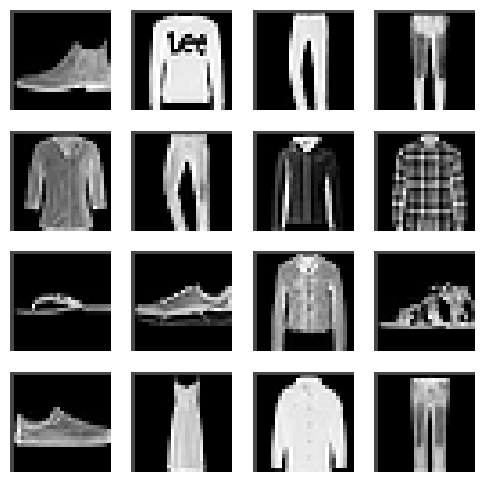

In [37]:
show_images(learn.batch[0][:16], imsize=1.5)

accuracy,loss,epoch,train
0.704,1.068,0,True
0.795,0.658,0,False
0.808,0.746,1,True
0.835,0.537,1,False
0.838,0.598,2,True
0.848,0.465,2,False
0.839,0.538,3,True
0.846,0.464,3,False
0.850,0.467,4,True
0.836,0.508,4,False


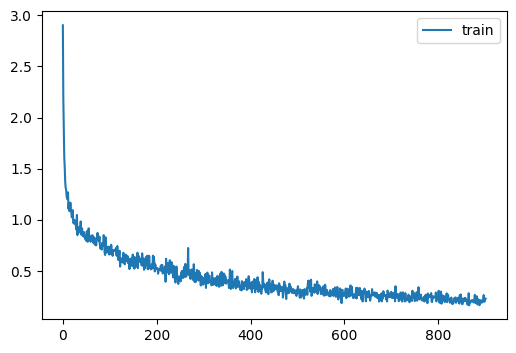

In [ ]:
set_seed(42)
epochs = 20
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=len(dls.train)*epochs)
xtra = [DeviceCB(), BatchSchedCB(sched), BatchTransformCB(partial(f, tfm_x=tfms), on_val=False)]
learn = TrainLearner(get_model4().apply(iw), dls, F.cross_entropy, lr=lr, cbs= cbs + xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
path = fc.Path('models')
path.mkdir(exist_ok=True)
torch.save(learn.model, path/'fmnist_random_copy.pkl')

In [42]:
TrainLearner(learn.model, dls, F.cross_entropy, cbs=[DeviceCB(), metrics, ProgressCB(plot=True)]).fit(1, train=False)

accuracy,loss,epoch,train
0.934,0.184,0,False


In [43]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(p=0.5),
                     RandomErase(),
                     RandomCopy()
                    )

accuracy,loss,epoch,train
0.679,1.134,0,True
0.767,0.703,0,False
0.786,0.807,1,True
0.808,0.593,1,False
0.819,0.677,2,True
0.830,0.519,2,False
0.826,0.592,3,True
0.836,0.467,3,False
0.820,0.567,4,True
0.840,0.478,4,False


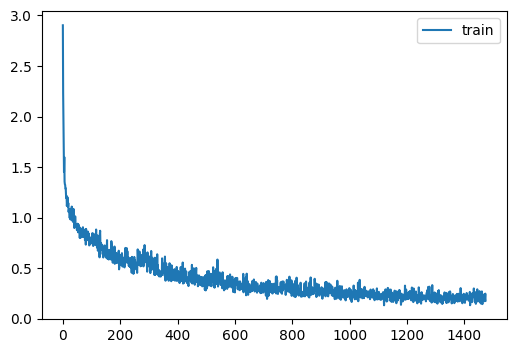

In [ ]:
set_seed(42)
epochs = 25
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=len(dls.train)*epochs)
xtra = [DeviceCB(), BatchSchedCB(sched), BatchTransformCB(partial(f, tfm_x=tfms), on_val=False)]
learn = TrainLearner(get_model4().apply(iw), dls, F.cross_entropy, lr=lr, cbs= cbs + xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [45]:
path = fc.Path('models')
path.mkdir(exist_ok=True)
torch.save(learn.model, path/'fmnist_random_copy_erase.pkl')

## Ensemble